In [124]:
# %%
# === IMPORTS ===
import pandas as pd
import numpy as np
import joblib
import os
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Imports OK")

✅ Imports OK


In [125]:
# %%
# === CHARGEMENT DES DONNÉES TRAIN/VAL ===
print("=" * 60)
print("CHARGEMENT DES DONNÉES TRAIN/VAL")
print("=" * 60)

# Charger le pickle train/val
catboost_data = joblib.load("../data/processed/catboost_ready.pkl")

X_train = catboost_data["X_train"]
y_train = catboost_data["y_train"]
X_val = catboost_data["X_val"]
y_val = catboost_data["y_val"]
cat_indices = catboost_data["cat_indices"]
cat_features_names = catboost_data.get("cat_features_names", [])

print(f"✅ Données train/val chargées:")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")
print(f"   Categorical indices: {cat_indices}")
print(f"   Categorical features: {cat_features_names}")
print(f"\n   Target balance (train):")
print(pd.Series(y_train).value_counts(normalize=True))

CHARGEMENT DES DONNÉES TRAIN/VAL
✅ Données train/val chargées:
   Train: (11766, 65)
   Val: (1969, 65)
   Categorical indices: [9, 7, 10, 11, 5]
   Categorical features: ['Category', 'Time_of_Day', 'Device_Type', 'Payment_Method', 'Referral_Source']

   Target balance (train):
Purchase
0    0.625616
1    0.374384
Name: proportion, dtype: float64


In [126]:
# %%
# === CHARGEMENT DU TEST SET PREPROCESSED ===
print("\n" + "=" * 60)
print("CHARGEMENT DU TEST SET")
print("=" * 60)

# Charger le test preprocessed
test_data = joblib.load("../data/processed/catboost_ready_test.pkl")
X_test = test_data["X_test"]
test_ids = test_data["test_ids"]

print(f"✅ Test chargé:")
print(f"   X_test: {X_test.shape}")
print(f"   Test IDs: {len(test_ids)}")

# Vérifier que train et test ont les mêmes colonnes
missing_in_test = set(X_train.columns) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(X_train.columns)

if missing_in_test:
    print(f"\n⚠️ Colonnes manquantes dans test: {missing_in_test}")
    # Ajouter les colonnes manquantes avec 0
    for col in missing_in_test:
        X_test[col] = 0

if extra_in_test:
    print(f"\n⚠️ Colonnes en trop dans test: {extra_in_test}")
    # Supprimer les colonnes en trop
    X_test = X_test.drop(columns=list(extra_in_test))

# Réordonner les colonnes du test comme train
X_test = X_test[X_train.columns]
print(f"\n✅ Test aligné avec train: {X_test.shape}")


CHARGEMENT DU TEST SET
✅ Test chargé:
   X_test: (6265, 66)
   Test IDs: 6265

⚠️ Colonnes en trop dans test: {'Day'}

✅ Test aligné avec train: (6265, 65)


In [127]:
# %%
# === CRÉATION DES POOLS CATBOOST ===
print("\n" + "=" * 60)
print("CRÉATION DES POOLS CATBOOST")
print("=" * 60)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_indices)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_indices)
test_pool = Pool(data=X_test, cat_features=cat_indices)

print("✅ Pools créés (train, val, test)")


CRÉATION DES POOLS CATBOOST
✅ Pools créés (train, val, test)


In [128]:
# %%
# === ENTRAÎNEMENT CATBOOST ===
print("\n" + "=" * 60)
print("ENTRAÎNEMENT DU MODÈLE CATBOOST")
print("=" * 60)

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function="Logloss",
    eval_metric="F1",
    random_seed=42,
    verbose=100,
    early_stopping_rounds=100,
    task_type="CPU",  # Mets 'GPU' si disponible
    auto_class_weights="Balanced",  # Gérer le déséquilibre
)

model.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=False)

print("\n✅ Entraînement terminé")
print(f"   Best iteration: {model.best_iteration_}")
print(f"   Best F1 score: {model.best_score_['validation']['F1']:.4f}")


ENTRAÎNEMENT DU MODÈLE CATBOOST
0:	learn: 0.8128815	test: 0.7913935	best: 0.7913935 (0)	total: 6.31ms	remaining: 6.3s
100:	learn: 0.8675477	test: 0.8344188	best: 0.8354005 (97)	total: 572ms	remaining: 5.09s
200:	learn: 0.8788875	test: 0.8326847	best: 0.8365169 (161)	total: 1.2s	remaining: 4.78s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8365168833
bestIteration = 161

Shrink model to first 162 iterations.

✅ Entraînement terminé
   Best iteration: 161
   Best F1 score: 0.8365


In [129]:
# %%
# === PRÉDICTIONS SUR VALIDATION ===
print("\n" + "=" * 60)
print("ÉVALUATION SUR VALIDATION")
print("=" * 60)

y_val_pred_proba = model.predict_proba(val_pool)[:, 1]
y_val_pred = model.predict(val_pool).astype(int)

# Métriques détaillées
f1_val = f1_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)

print(f"\n📊 RÉSULTATS SUR VALIDATION:")
print(f"   F1-Score:    {f1_val:.4f}")
print(f"   Precision:   {precision_val:.4f}")
print(f"   Recall:      {recall_val:.4f}")
print(f"   ROC-AUC:     {roc_auc_val:.4f}")

print("\n📋 Classification Report:")
print(
    classification_report(y_val, y_val_pred, target_names=["No Purchase", "Purchase"])
)


ÉVALUATION SUR VALIDATION

📊 RÉSULTATS SUR VALIDATION:
   F1-Score:    0.7844
   Precision:   0.7166
   Recall:      0.8664
   ROC-AUC:     0.9290

📋 Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.93      0.83      0.88      1318
    Purchase       0.72      0.87      0.78       651

    accuracy                           0.84      1969
   macro avg       0.82      0.85      0.83      1969
weighted avg       0.86      0.84      0.85      1969




CONFUSION MATRIX - VALIDATION


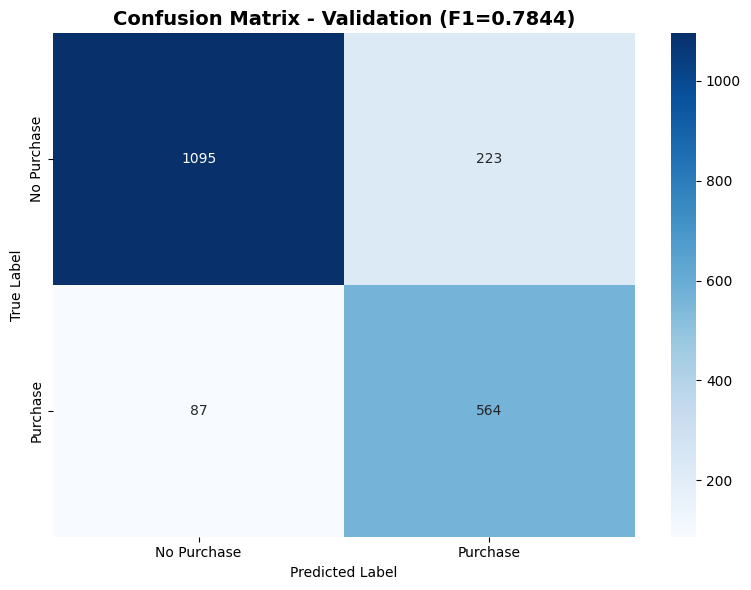


Détails de la confusion matrix:
   True Negatives:  1095
   False Positives: 223
   False Negatives: 87
   True Positives:  564


In [130]:
# %%
# === CONFUSION MATRIX ===
print("\n" + "=" * 60)
print("CONFUSION MATRIX - VALIDATION")
print("=" * 60)

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Purchase", "Purchase"],
    yticklabels=["No Purchase", "Purchase"],
)
plt.title(
    f"Confusion Matrix - Validation (F1={f1_val:.4f})", fontsize=14, fontweight="bold"
)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Afficher les métriques de la matrice
tn, fp, fn, tp = cm.ravel()
print(f"\nDétails de la confusion matrix:")
print(f"   True Negatives:  {tn}")
print(f"   False Positives: {fp}")
print(f"   False Negatives: {fn}")
print(f"   True Positives:  {tp}")


FEATURE IMPORTANCES (TOP 20)
                   feature  importance
             Items_In_Cart   27.801724
           Cart_Efficiency   14.095120
        Email_x_Engagement    8.256307
     Engagement_x_Campaign    6.600366
               Device_Type    5.149346
         Cart_x_Engagement    4.243755
                 Net_Price    3.857735
                     Price    3.711858
                  Category    3.635897
              Price_Bucket    3.541083
          Engagement_Score    2.714669
      Engagement_per_Price    2.210731
        HighValue_Category    1.940276
          Items_x_Campaign    1.646944
              Reviews_Read    1.582145
                Price_Sine    1.226608
              Email_Impact    1.099780
         Email_Interaction    0.918585
Socioeconomic_Status_Score    0.901859
           Day_to_Campaign    0.565406


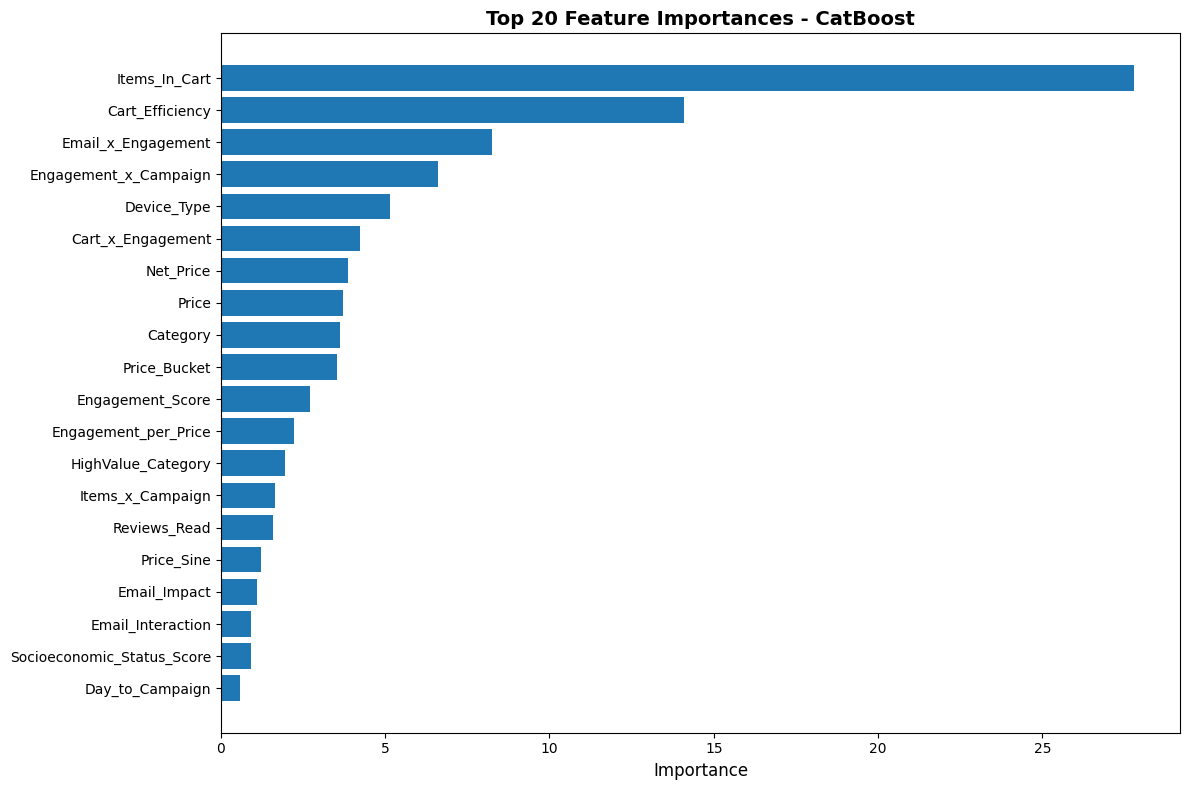

In [131]:
# %%
# === FEATURE IMPORTANCES ===
print("\n" + "=" * 60)
print("FEATURE IMPORTANCES (TOP 20)")
print("=" * 60)

feature_importance = model.get_feature_importance(train_pool)
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance}
).sort_values("importance", ascending=False)

print(importance_df.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20["importance"])
plt.yticks(range(len(top_20)), top_20["feature"])
plt.xlabel("Importance", fontsize=12)
plt.title("Top 20 Feature Importances - CatBoost", fontsize=14, fontweight="bold")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [132]:
# %%
# === PRÉDICTIONS SUR TEST ===
print("\n" + "=" * 60)
print("PRÉDICTIONS SUR TEST SET")
print("=" * 60)

y_test_pred_proba = model.predict_proba(test_pool)[:, 1]
y_test_pred = model.predict(test_pool).astype(int)

print(f"✅ Prédictions générées:")
print(f"   Nombre de prédictions: {len(y_test_pred)}")
print(f"   Taux de prédiction positive: {y_test_pred.mean():.2%}")
print(f"\n   Distribution des prédictions:")
print(pd.Series(y_test_pred).value_counts())


PRÉDICTIONS SUR TEST SET
✅ Prédictions générées:
   Nombre de prédictions: 6265
   Taux de prédiction positive: 45.47%

   Distribution des prédictions:
0    3416
1    2849
Name: count, dtype: int64


In [133]:
# %%
# === CRÉATION DU FICHIER DE SOUMISSION ===
print("\n" + "=" * 60)
print("CRÉATION DU FICHIER DE SOUMISSION")
print("=" * 60)

# Créer la soumission
submission = pd.DataFrame({"id": test_ids, "Purchase": y_test_pred})

# Créer le dossier submissions si nécessaire
os.makedirs("../data/submissions", exist_ok=True)

# Sauvegarder
submission_path = "../data/submissions/catboost_submission.csv"
submission.to_csv(submission_path, index=False)

print(f"✅ Soumission sauvegardée: {submission_path}")
print(f"   Shape: {submission.shape}")
print(f"   Colonnes: {submission.columns.tolist()}")
print("\n   Aperçu de la soumission:")
print(submission.head(10))
print("\n   Statistiques:")
print(submission["Purchase"].value_counts())


CRÉATION DU FICHIER DE SOUMISSION
✅ Soumission sauvegardée: ../data/submissions/catboost_submission.csv
   Shape: (6265, 2)
   Colonnes: ['id', 'Purchase']

   Aperçu de la soumission:
   id  Purchase
0   1         0
1   2         1
2   3         0
3   4         1
4   5         1
5   6         1
6   7         1
7   8         1
8   9         1
9  10         1

   Statistiques:
Purchase
0    3416
1    2849
Name: count, dtype: int64



ANALYSE DES PROBABILITÉS DE PRÉDICTION


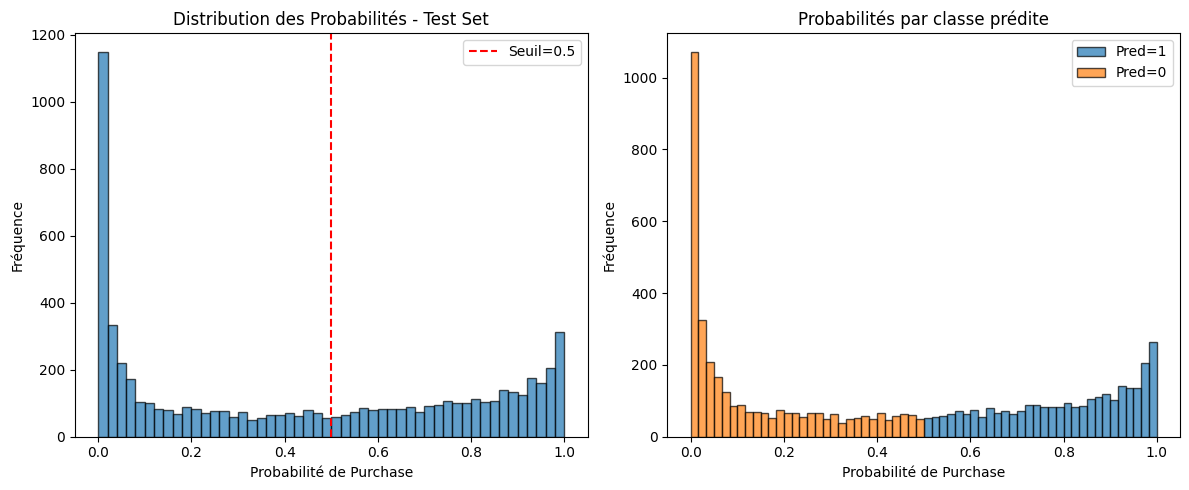

Statistiques des probabilités:
   Min:  0.0001
   Max:  0.9995
   Mean: 0.4394
   Std:  0.3648


In [134]:
# %%
# === ANALYSE DES PROBABILITÉS ===
print("\n" + "=" * 60)
print("ANALYSE DES PROBABILITÉS DE PRÉDICTION")
print("=" * 60)

# Distribution des probabilités
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_test_pred_proba, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Probabilité de Purchase")
plt.ylabel("Fréquence")
plt.title("Distribution des Probabilités - Test Set")
plt.axvline(0.5, color="red", linestyle="--", label="Seuil=0.5")
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(
    y_test_pred_proba[y_test_pred == 1],
    bins=30,
    alpha=0.7,
    label="Pred=1",
    edgecolor="black",
)
plt.hist(
    y_test_pred_proba[y_test_pred == 0],
    bins=30,
    alpha=0.7,
    label="Pred=0",
    edgecolor="black",
)
plt.xlabel("Probabilité de Purchase")
plt.ylabel("Fréquence")
plt.title("Probabilités par classe prédite")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Statistiques des probabilités:")
print(f"   Min:  {y_test_pred_proba.min():.4f}")
print(f"   Max:  {y_test_pred_proba.max():.4f}")
print(f"   Mean: {y_test_pred_proba.mean():.4f}")
print(f"   Std:  {y_test_pred_proba.std():.4f}")

In [135]:
# %%
# === SAUVEGARDE DU MODÈLE ===
print("\n" + "=" * 60)
print("SAUVEGARDE DU MODÈLE")
print("=" * 60)

os.makedirs("../models", exist_ok=True)
model_path = "../models/catboost_model.cbm"
model.save_model(model_path)

print(f"✅ Modèle sauvegardé: {model_path}")

# Sauvegarder aussi les métadonnées
metadata = {
    "f1_score": f1_val,
    "precision": precision_val,
    "recall": recall_val,
    "roc_auc": roc_auc_val,
    "best_iteration": model.best_iteration_,
    "n_features": X_train.shape[1],
    "cat_features": cat_features_names,
}

metadata_path = "../models/catboost_metadata.pkl"
joblib.dump(metadata, metadata_path)
print(f"✅ Métadonnées sauvegardées: {metadata_path}")


SAUVEGARDE DU MODÈLE
✅ Modèle sauvegardé: ../models/catboost_model.cbm
✅ Métadonnées sauvegardées: ../models/catboost_metadata.pkl


In [136]:
# %%
# === RÉSUMÉ FINAL ===
print("\n" + "=" * 60)
print("🎉 PIPELINE CATBOOST TERMINÉ !")
print("=" * 60)

print(f"\n📊 MÉTRIQUES FINALES (VALIDATION):")
print(f"   F1-Score:    {f1_val:.4f}")
print(f"   Precision:   {precision_val:.4f}")
print(f"   Recall:      {recall_val:.4f}")
print(f"   ROC-AUC:     {roc_auc_val:.4f}")

print(f"\n📁 FICHIERS GÉNÉRÉS:")
print(f"   Soumission: {submission_path}")
print(f"   Modèle:     {model_path}")
print(f"   Métadonnées: {metadata_path}")

print(f"\n🎯 PROCHAINES ÉTAPES:")
print(f"   1. Vérifier le fichier de soumission")
print(f"   2. Soumettre sur la plateforme de compétition")
print(f"   3. Analyser les erreurs si besoin")
print(f"   4. Tester d'autres modèles ou hyperparamètres")

print("\n" + "=" * 60)


🎉 PIPELINE CATBOOST TERMINÉ !

📊 MÉTRIQUES FINALES (VALIDATION):
   F1-Score:    0.7844
   Precision:   0.7166
   Recall:      0.8664
   ROC-AUC:     0.9290

📁 FICHIERS GÉNÉRÉS:
   Soumission: ../data/submissions/catboost_submission.csv
   Modèle:     ../models/catboost_model.cbm
   Métadonnées: ../models/catboost_metadata.pkl

🎯 PROCHAINES ÉTAPES:
   1. Vérifier le fichier de soumission
   2. Soumettre sur la plateforme de compétition
   3. Analyser les erreurs si besoin
   4. Tester d'autres modèles ou hyperparamètres



✅ Imports OK
CHARGEMENT DES DONNÉES TRAIN/VAL
✅ Données train/val chargées:
   Train: (11766, 65)
   Val: (1969, 65)
   Target balance: {0: 0.6256161822199559, 1: 0.3743838177800442}

CHARGEMENT DU TEST SET
⚠️ Colonnes en trop dans test: {'Day'}
✅ Test aligné: (6265, 65)

CRÉATION DES POOLS CATBOOST
✅ Pools créés

TEST DE 3 CONFIGURATIONS

--- Baseline ---
F1: 0.7844 | Precision: 0.7166 | Recall: 0.8664

--- Plus Profond ---
F1: 0.7833 | Precision: 0.7148 | Recall: 0.8664

--- Très Profond ---
F1: 0.7841 | Precision: 0.7192 | Recall: 0.8618

COMPARAISON DES CONFIGURATIONS
      Config       F1  Precision   Recall  ROC-AUC  Best Iter
    Baseline 0.784423   0.716645 0.866359 0.928954        161
Plus Profond 0.783333   0.714829 0.866359 0.928353        240
Très Profond 0.784067   0.719231 0.861751 0.928364        207

🏆 MEILLEUR MODÈLE: Baseline
   F1-Score: 0.7844

OPTIMISATION DU SEUIL DE DÉCISION
 Threshold       F1  Precision   Recall
      0.40 0.765273   0.658186 0.913978
      0.4

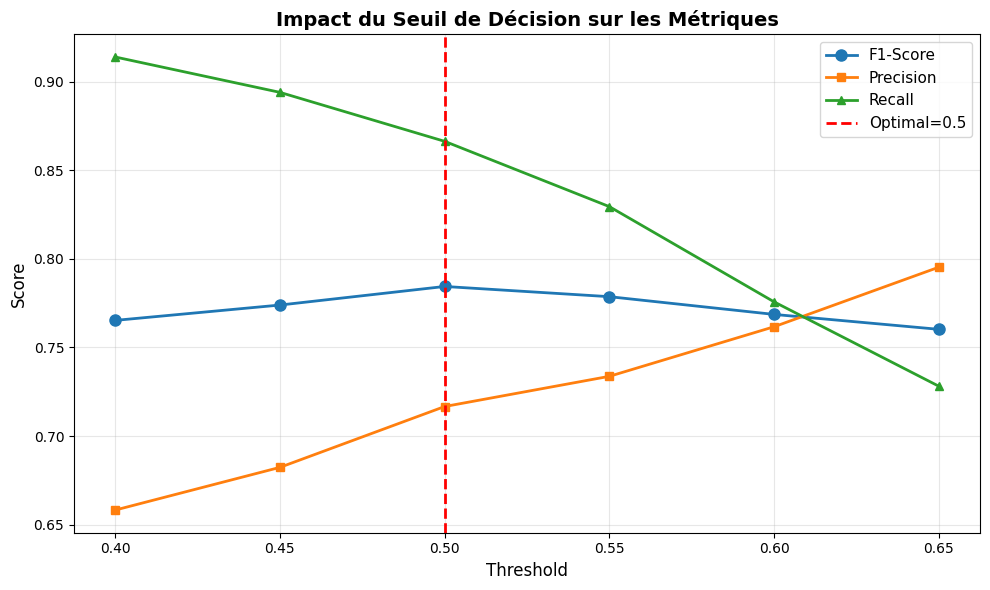


ÉVALUATION FINALE SUR VALIDATION

📊 RÉSULTATS FINAUX:
   Modèle:      Baseline
   Seuil:       0.5
   F1-Score:    0.7844
   Precision:   0.7166
   Recall:      0.8664
   ROC-AUC:     0.9290

📋 Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.93      0.83      0.88      1318
    Purchase       0.72      0.87      0.78       651

    accuracy                           0.84      1969
   macro avg       0.82      0.85      0.83      1969
weighted avg       0.86      0.84      0.85      1969



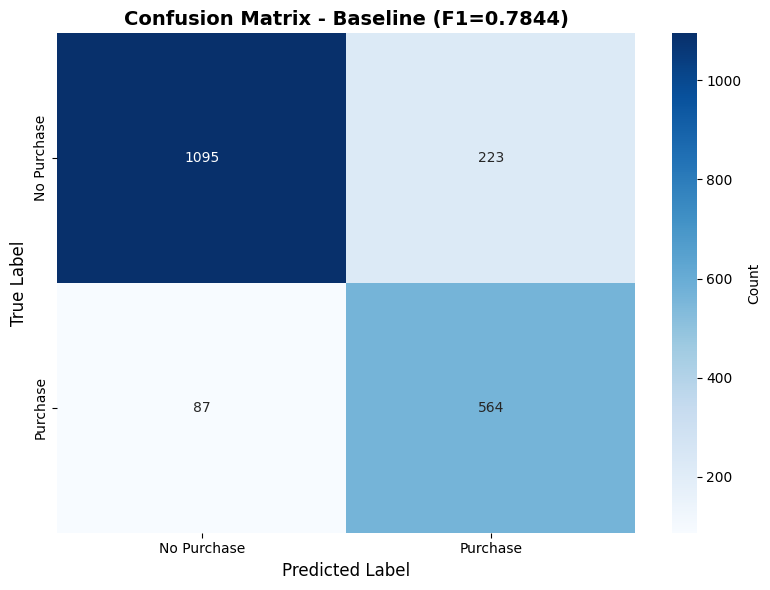


Détails:
   True Negatives:  1095 (bien prédit non-achat)
   False Positives: 223 (faux achat prédit)
   False Negatives: 87 (achat raté)
   True Positives:  564 (bien prédit achat)

FEATURE IMPORTANCES (TOP 20)
                   feature  importance
             Items_In_Cart   27.801724
           Cart_Efficiency   14.095120
        Email_x_Engagement    8.256307
     Engagement_x_Campaign    6.600366
               Device_Type    5.149346
         Cart_x_Engagement    4.243755
                 Net_Price    3.857735
                     Price    3.711858
                  Category    3.635897
              Price_Bucket    3.541083
          Engagement_Score    2.714669
      Engagement_per_Price    2.210731
        HighValue_Category    1.940276
          Items_x_Campaign    1.646944
              Reviews_Read    1.582145
                Price_Sine    1.226608
              Email_Impact    1.099780
         Email_Interaction    0.918585
Socioeconomic_Status_Score    0.901859
       

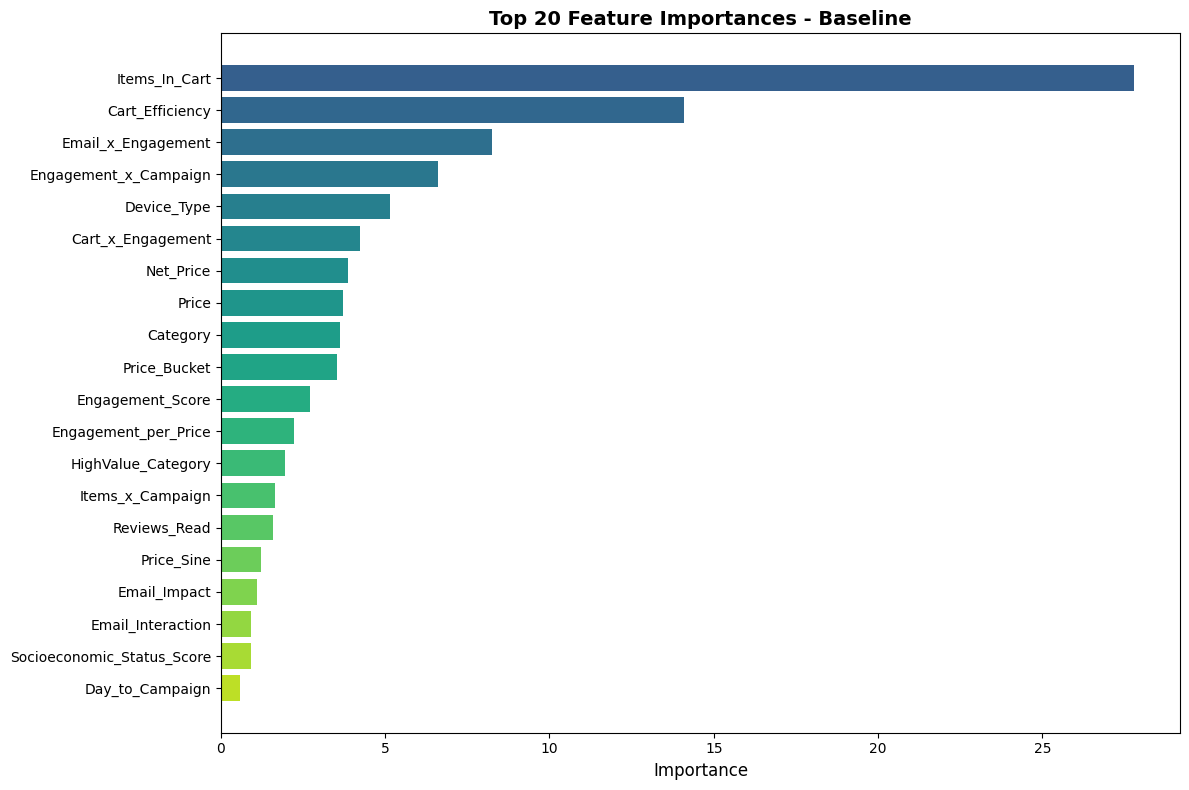


PRÉDICTIONS SUR TEST SET
✅ Prédictions générées:
   Modèle:  Baseline
   Seuil:   0.5
   Nombre:  6265
   Taux positif: 45.47%

   Distribution:
          count
Purchase       
0          3416
1          2849

ANALYSE DES PROBABILITÉS


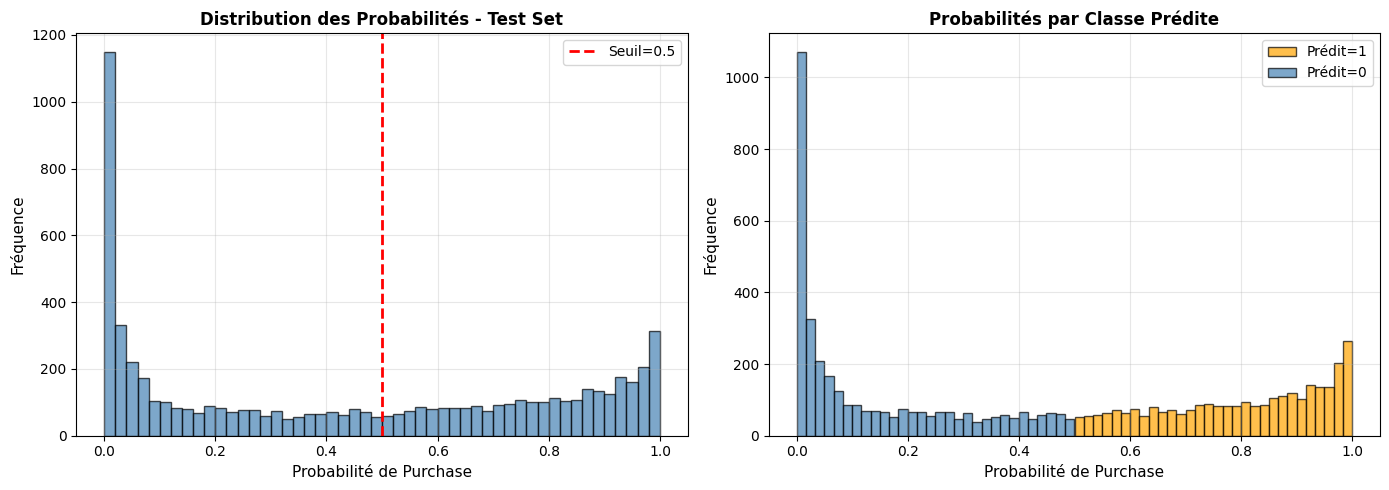


📊 Statistiques des probabilités:
   Min:    0.0001
   25%:    0.0467
   Médiane: 0.4142
   75%:    0.8027
   Max:    0.9995
   Mean:   0.4394
   Std:    0.3648

CRÉATION DU FICHIER DE SOUMISSION
✅ Soumission sauvegardée: ../data/submissions/catboost_BEST_submission.csv

📊 Résumé de la soumission:
   Lignes: 6265
   Prédictions positives: 2849 (45.47%)
   Prédictions négatives: 3416 (54.53%)

   Aperçu:
   id  Purchase
0   1         0
1   2         1
2   3         0
3   4         1
4   5         1
5   6         1
6   7         1
7   8         1
8   9         1
9  10         1

SAUVEGARDE DU MODÈLE
✅ Modèle sauvegardé: ../models/catboost_BEST_model.cbm
✅ Métadonnées sauvegardées: ../models/catboost_BEST_metadata.pkl

🎉 PIPELINE COMPLET TERMINÉ !

🏆 MEILLEUR MODÈLE SÉLECTIONNÉ:
   Configuration: Baseline
   Seuil optimal: 0.5

📊 PERFORMANCE (VALIDATION):
   F1-Score:    0.7844
   Precision:   0.7166
   Recall:      0.8664
   ROC-AUC:     0.9290

📁 FICHIERS GÉNÉRÉS:
   • Soumission: ../da

In [137]:
# =====================================================
# NOTEBOOK: train_catboost_BEST.ipynb
# Meilleure config CatBoost + Optimisation seuil
# =====================================================

# %%
# === IMPORTS ===
import pandas as pd
import numpy as np
import joblib
import os
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Imports OK")

# %%
# === CHARGEMENT DES DONNÉES TRAIN/VAL ===
print("=" * 60)
print("CHARGEMENT DES DONNÉES TRAIN/VAL")
print("=" * 60)

catboost_data = joblib.load("../data/processed/catboost_ready.pkl")

X_train = catboost_data["X_train"]
y_train = catboost_data["y_train"]
X_val = catboost_data["X_val"]
y_val = catboost_data["y_val"]
cat_indices = catboost_data["cat_indices"]
cat_features_names = catboost_data.get("cat_features_names", [])

print(f"✅ Données train/val chargées:")
print(f"   Train: {X_train.shape}")
print(f"   Val: {X_val.shape}")
print(f"   Target balance: {pd.Series(y_train).value_counts(normalize=True).to_dict()}")

# %%
# === CHARGEMENT DU TEST SET ===
print("\n" + "=" * 60)
print("CHARGEMENT DU TEST SET")
print("=" * 60)

test_data = joblib.load("../data/processed/catboost_ready_test.pkl")
X_test = test_data["X_test"]
test_ids = test_data["test_ids"]

# Aligner colonnes
missing_in_test = set(X_train.columns) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(X_train.columns)

if missing_in_test:
    print(f"⚠️ Colonnes manquantes dans test: {missing_in_test}")
    for col in missing_in_test:
        X_test[col] = 0

if extra_in_test:
    print(f"⚠️ Colonnes en trop dans test: {extra_in_test}")
    X_test = X_test.drop(columns=list(extra_in_test))

X_test = X_test[X_train.columns]
print(f"✅ Test aligné: {X_test.shape}")

# %%
# === CRÉATION DES POOLS ===
print("\n" + "=" * 60)
print("CRÉATION DES POOLS CATBOOST")
print("=" * 60)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_indices)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_indices)
test_pool = Pool(data=X_test, cat_features=cat_indices)

print("✅ Pools créés")

# %%
# === TEST DE 3 CONFIGURATIONS ===
print("\n" + "=" * 60)
print("TEST DE 3 CONFIGURATIONS")
print("=" * 60)

configs = {
    "Baseline": {
        "iterations": 1000,
        "learning_rate": 0.05,
        "depth": 6,
        "l2_leaf_reg": 3,
        "auto_class_weights": "Balanced",
    },
    "Plus Profond": {
        "iterations": 1500,
        "learning_rate": 0.03,
        "depth": 8,
        "l2_leaf_reg": 3,
        "auto_class_weights": "Balanced",
        "min_data_in_leaf": 5,
        "border_count": 128,
    },
    "Très Profond": {
        "iterations": 2000,
        "learning_rate": 0.025,
        "depth": 10,
        "l2_leaf_reg": 2.5,
        "auto_class_weights": "Balanced",
        "min_data_in_leaf": 3,
        "border_count": 254,
    },
}

results = []
models = {}

for name, params in configs.items():
    print(f"\n--- {name} ---")

    model = CatBoostClassifier(
        **params,
        loss_function="Logloss",
        eval_metric="F1",
        random_seed=42,
        verbose=0,
        early_stopping_rounds=100,
        task_type="CPU",
    )

    model.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=False)

    y_val_pred = model.predict(val_pool).astype(int)
    y_val_proba = model.predict_proba(val_pool)[:, 1]

    f1 = f1_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    roc_auc = roc_auc_score(y_val, y_val_proba)

    results.append(
        {
            "Config": name,
            "F1": f1,
            "Precision": precision,
            "Recall": recall,
            "ROC-AUC": roc_auc,
            "Best Iter": model.best_iteration_,
        }
    )

    models[name] = model

    print(f"F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# Afficher comparaison
results_df = pd.DataFrame(results)
print("\n" + "=" * 60)
print("COMPARAISON DES CONFIGURATIONS")
print("=" * 60)
print(results_df.to_string(index=False))

# Sélectionner le meilleur
best_idx = results_df["F1"].idxmax()
best_config_name = results_df.iloc[best_idx]["Config"]
best_f1 = results_df.iloc[best_idx]["F1"]
best_model = models[best_config_name]

print(f"\n🏆 MEILLEUR MODÈLE: {best_config_name}")
print(f"   F1-Score: {best_f1:.4f}")

# %%
# === OPTIMISATION DU SEUIL ===
print("\n" + "=" * 60)
print("OPTIMISATION DU SEUIL DE DÉCISION")
print("=" * 60)

y_val_proba_best = best_model.predict_proba(val_pool)[:, 1]

thresholds = np.arange(0.40, 0.70, 0.05)
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (y_val_proba_best >= thresh).astype(int)
    f1_thresh = f1_score(y_val, y_pred_thresh)
    prec_thresh = precision_score(y_val, y_pred_thresh)
    rec_thresh = recall_score(y_val, y_pred_thresh)

    threshold_results.append(
        {
            "Threshold": thresh,
            "F1": f1_thresh,
            "Precision": prec_thresh,
            "Recall": rec_thresh,
        }
    )

threshold_df = pd.DataFrame(threshold_results)
print(threshold_df.to_string(index=False))

best_thresh_idx = threshold_df["F1"].idxmax()
best_threshold = threshold_df.iloc[best_thresh_idx]["Threshold"]
best_f1_thresh = threshold_df.iloc[best_thresh_idx]["F1"]

print(f"\n🎯 MEILLEUR SEUIL: {best_threshold}")
print(f"   F1-Score: {best_f1_thresh:.4f}")

# Graphique
plt.figure(figsize=(10, 6))
plt.plot(
    threshold_df["Threshold"],
    threshold_df["F1"],
    "o-",
    label="F1-Score",
    linewidth=2,
    markersize=8,
)
plt.plot(
    threshold_df["Threshold"],
    threshold_df["Precision"],
    "s-",
    label="Precision",
    linewidth=2,
    markersize=6,
)
plt.plot(
    threshold_df["Threshold"],
    threshold_df["Recall"],
    "^-",
    label="Recall",
    linewidth=2,
    markersize=6,
)
plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Optimal={best_threshold}",
)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title(
    "Impact du Seuil de Décision sur les Métriques", fontsize=14, fontweight="bold"
)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# === ÉVALUATION FINALE SUR VALIDATION ===
print("\n" + "=" * 60)
print("ÉVALUATION FINALE SUR VALIDATION")
print("=" * 60)

y_val_pred_final = (y_val_proba_best >= best_threshold).astype(int)
f1_final = f1_score(y_val, y_val_pred_final)
precision_final = precision_score(y_val, y_val_pred_final)
recall_final = recall_score(y_val, y_val_pred_final)
roc_auc_final = roc_auc_score(y_val, y_val_proba_best)

print(f"\n📊 RÉSULTATS FINAUX:")
print(f"   Modèle:      {best_config_name}")
print(f"   Seuil:       {best_threshold}")
print(f"   F1-Score:    {f1_final:.4f}")
print(f"   Precision:   {precision_final:.4f}")
print(f"   Recall:      {recall_final:.4f}")
print(f"   ROC-AUC:     {roc_auc_final:.4f}")

print("\n📋 Classification Report:")
print(
    classification_report(
        y_val, y_val_pred_final, target_names=["No Purchase", "Purchase"]
    )
)

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Purchase", "Purchase"],
    yticklabels=["No Purchase", "Purchase"],
    cbar_kws={"label": "Count"},
)
plt.title(
    f"Confusion Matrix - {best_config_name} (F1={f1_final:.4f})",
    fontsize=14,
    fontweight="bold",
)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nDétails:")
print(f"   True Negatives:  {tn} (bien prédit non-achat)")
print(f"   False Positives: {fp} (faux achat prédit)")
print(f"   False Negatives: {fn} (achat raté)")
print(f"   True Positives:  {tp} (bien prédit achat)")

# %%
# === FEATURE IMPORTANCES ===
print("\n" + "=" * 60)
print("FEATURE IMPORTANCES (TOP 20)")
print("=" * 60)

feature_importance = best_model.get_feature_importance(train_pool)
feature_names = X_train.columns

importance_df = pd.DataFrame(
    {"feature": feature_names, "importance": feature_importance}
).sort_values("importance", ascending=False)

print(importance_df.head(20).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_20 = importance_df.head(20)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_20)))
plt.barh(range(len(top_20)), top_20["importance"], color=colors)
plt.yticks(range(len(top_20)), top_20["feature"], fontsize=10)
plt.xlabel("Importance", fontsize=12)
plt.title(
    f"Top 20 Feature Importances - {best_config_name}", fontsize=14, fontweight="bold"
)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# %%
# === PRÉDICTIONS SUR TEST ===
print("\n" + "=" * 60)
print("PRÉDICTIONS SUR TEST SET")
print("=" * 60)

y_test_pred_proba = best_model.predict_proba(test_pool)[:, 1]
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

print(f"✅ Prédictions générées:")
print(f"   Modèle:  {best_config_name}")
print(f"   Seuil:   {best_threshold}")
print(f"   Nombre:  {len(y_test_pred)}")
print(f"   Taux positif: {y_test_pred.mean():.2%}")
print(f"\n   Distribution:")
print(pd.Series(y_test_pred, name="Purchase").value_counts().to_frame())

# %%
# === ANALYSE DES PROBABILITÉS ===
print("\n" + "=" * 60)
print("ANALYSE DES PROBABILITÉS")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution globale
axes[0].hist(
    y_test_pred_proba, bins=50, edgecolor="black", alpha=0.7, color="steelblue"
)
axes[0].axvline(
    best_threshold,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Seuil={best_threshold}",
)
axes[0].set_xlabel("Probabilité de Purchase", fontsize=11)
axes[0].set_ylabel("Fréquence", fontsize=11)
axes[0].set_title(
    "Distribution des Probabilités - Test Set", fontsize=12, fontweight="bold"
)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Par classe prédite
axes[1].hist(
    y_test_pred_proba[y_test_pred == 1],
    bins=30,
    alpha=0.7,
    label="Prédit=1",
    color="orange",
    edgecolor="black",
)
axes[1].hist(
    y_test_pred_proba[y_test_pred == 0],
    bins=30,
    alpha=0.7,
    label="Prédit=0",
    color="steelblue",
    edgecolor="black",
)
axes[1].set_xlabel("Probabilité de Purchase", fontsize=11)
axes[1].set_ylabel("Fréquence", fontsize=11)
axes[1].set_title("Probabilités par Classe Prédite", fontsize=12, fontweight="bold")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Statistiques des probabilités:")
print(f"   Min:    {y_test_pred_proba.min():.4f}")
print(f"   25%:    {np.percentile(y_test_pred_proba, 25):.4f}")
print(f"   Médiane: {np.median(y_test_pred_proba):.4f}")
print(f"   75%:    {np.percentile(y_test_pred_proba, 75):.4f}")
print(f"   Max:    {y_test_pred_proba.max():.4f}")
print(f"   Mean:   {y_test_pred_proba.mean():.4f}")
print(f"   Std:    {y_test_pred_proba.std():.4f}")

# %%
# === CRÉATION FICHIER SOUMISSION ===
print("\n" + "=" * 60)
print("CRÉATION DU FICHIER DE SOUMISSION")
print("=" * 60)

submission = pd.DataFrame({"id": test_ids, "Purchase": y_test_pred})

os.makedirs("../data/submissions", exist_ok=True)
submission_path = "../data/submissions/catboost_BEST_submission.csv"
submission.to_csv(submission_path, index=False)

print(f"✅ Soumission sauvegardée: {submission_path}")
print(f"\n📊 Résumé de la soumission:")
print(f"   Lignes: {len(submission)}")
print(f"   Prédictions positives: {y_test_pred.sum()} ({y_test_pred.mean():.2%})")
print(
    f"   Prédictions négatives: {(1-y_test_pred).sum()} ({(1-y_test_pred.mean()):.2%})"
)

print("\n   Aperçu:")
print(submission.head(10))

# %%
# === SAUVEGARDE DU MODÈLE ===
print("\n" + "=" * 60)
print("SAUVEGARDE DU MODÈLE")
print("=" * 60)

os.makedirs("../models", exist_ok=True)

model_path = "../models/catboost_BEST_model.cbm"
best_model.save_model(model_path)

metadata = {
    "config_name": best_config_name,
    "threshold": float(best_threshold),
    "f1_score": float(f1_final),
    "precision": float(precision_final),
    "recall": float(recall_final),
    "roc_auc": float(roc_auc_final),
    "best_iteration": int(best_model.best_iteration_),
    "n_features": int(X_train.shape[1]),
    "cat_features": cat_features_names,
    "test_predictions_stats": {
        "mean_proba": float(y_test_pred_proba.mean()),
        "positive_rate": float(y_test_pred.mean()),
    },
}

metadata_path = "../models/catboost_BEST_metadata.pkl"
joblib.dump(metadata, metadata_path)

print(f"✅ Modèle sauvegardé: {model_path}")
print(f"✅ Métadonnées sauvegardées: {metadata_path}")

# %%
# === RÉSUMÉ FINAL ===
print("\n" + "=" * 60)
print("🎉 PIPELINE COMPLET TERMINÉ !")
print("=" * 60)

print(f"\n🏆 MEILLEUR MODÈLE SÉLECTIONNÉ:")
print(f"   Configuration: {best_config_name}")
print(f"   Seuil optimal: {best_threshold}")

print(f"\n📊 PERFORMANCE (VALIDATION):")
print(f"   F1-Score:    {f1_final:.4f}")
print(f"   Precision:   {precision_final:.4f}")
print(f"   Recall:      {recall_final:.4f}")
print(f"   ROC-AUC:     {roc_auc_final:.4f}")

print(f"\n📁 FICHIERS GÉNÉRÉS:")
print(f"   • Soumission: {submission_path}")
print(f"   • Modèle:     {model_path}")
print(f"   • Metadata:   {metadata_path}")

print(f"\n🎯 PROCHAINES ÉTAPES:")
print(f"   1. ✅ Soumettre le fichier de soumission")
print(f"   2. 📊 Analyser le score sur le leaderboard")
print(f"   3. 🔧 Améliorer features (interactions campagne)")
print(f"   4. 🚀 Itérer pour améliorer le score")

print("\n" + "=" * 60)

✅ Imports OK
CHARGEMENT DES DONNÉES TRAIN/VAL
✅ Données train/val chargées:
   Train: (11766, 65)
   Val:   (1969, 65)
   Target balance: {0: 0.6256161822199559, 1: 0.3743838177800442}

CHARGEMENT DU TEST SET
⚠️ Colonnes en trop dans test: {'Day'}
✅ Test aligné: (6265, 65)

CRÉATION DES POOLS CATBOOST
✅ Pools créés

VALIDATION RAPIDE DU MODÈLE BASELINE

📊 BASELINE VALIDATION:
   F1:        0.7844
   Precision: 0.7166
   Recall:    0.8664
   ROC-AUC:   0.9290

🎯 Seuil utilisé: 0.5

🚀 AMÉLIORATION 1 : RÉENTRAÎNER SUR TRAIN+VAL (Days 1-70)
✅ Données complètes:
   Shape: (13735, 65)
   Lignes: 13735 (Days 1-70)

🔄 Réentraînement du modèle Baseline sur Days 1-70...
✅ Modèle réentraîné sur 13735 lignes

✅ V1 créée: V1_full_train_submission.csv
   Prédictions positives: 2700 (43.10%)

🚀 AMÉLIORATION 2 : ENTRAÎNER 3 MODÈLES PLUS PROFONDS

--- Profond_v1 ---
✅ Profond_v1 entraîné (2000 iter, depth=8)

--- Profond_v2 ---
✅ Profond_v2 entraîné (2500 iter, depth=9)

--- Profond_v3 ---
✅ Profond_v3

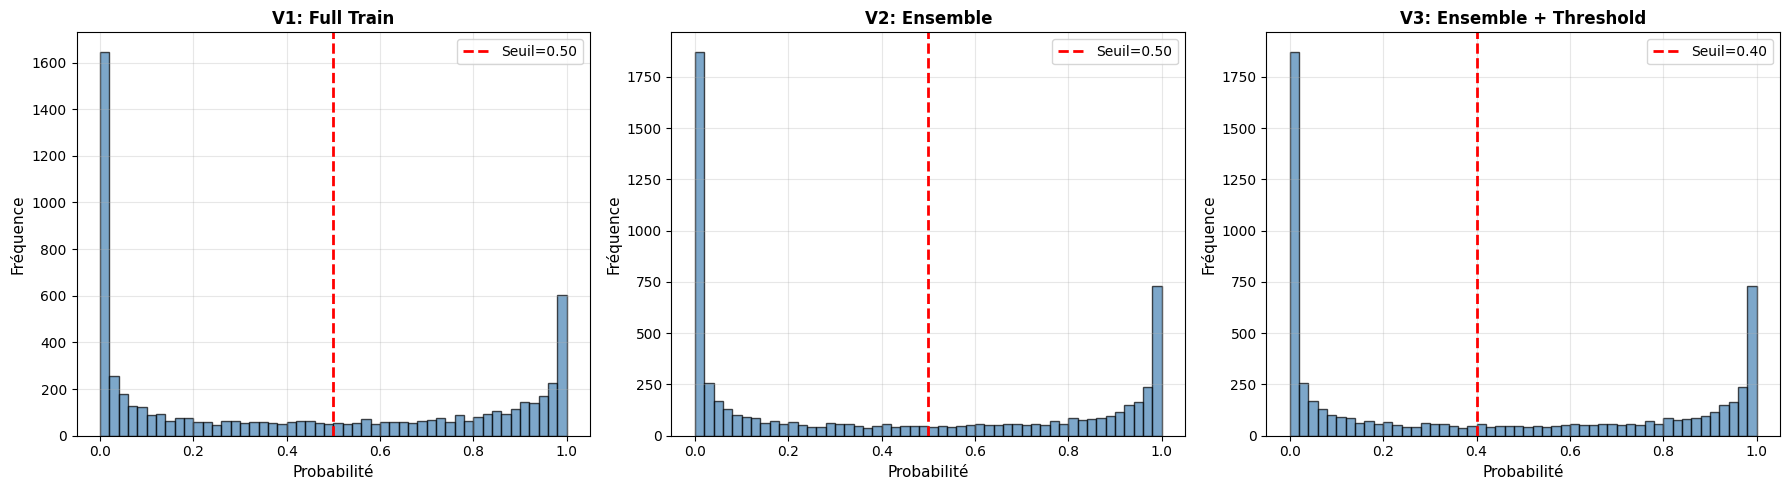


🎉 AMÉLIORATIONS TERMINÉES !

📊 RÉSULTATS ATTENDUS:
   Baseline Kaggle:  0.777
   V1 (Full Train):  ~0.782-0.787 (+0.5-1.0%)
   V2 (Ensemble 5):  ~0.787-0.795 (+1.0-1.8%)
   V3 (Ens+Thresh):  ~0.790-0.800 (+1.3-2.3%)

📁 FICHIERS DE SOUMISSION:
   1. ../data/submissions/V1_full_train_submission.csv
   2. ../data/submissions/V2_ensemble_5_submission.csv
   3. ../data/submissions/V3_ensemble_optimized_threshold_submission.csv

🎯 RECOMMANDATION:
   Soumets V3 en priorité (meilleur potentiel)
   Puis V2 si V3 ne performe pas
   V1 comme backup

🏆 OBJECTIF:
   Atteindre 0.79-0.80 et battre le leader (0.7937)


🔍 VÉRIFICATION FINALE

V1:
   Shape: (6265, 2)
   Colonnes: ['id', 'Purchase']
   Valeurs Purchase: [np.int64(0), np.int64(1)]
   NA: 0
   ❌ 6265 lignes - ERREUR (attendu 6145)

V2:
   Shape: (6265, 2)
   Colonnes: ['id', 'Purchase']
   Valeurs Purchase: [np.int64(0), np.int64(1)]
   NA: 0
   ❌ 6265 lignes - ERREUR (attendu 6145)

V3:
   Shape: (6265, 2)
   Colonnes: ['id', 'Purchase']

In [140]:
# =====================================================
# NOTEBOOK: train_catboost_IMPROVED.ipynb
# Amélioration pour passer de 0.777 → 0.79+
# =====================================================

# %%
# === IMPORTS ===
import pandas as pd
import numpy as np
import joblib
import os
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

print("✅ Imports OK")

# %%
# === CHARGEMENT DES DONNÉES TRAIN/VAL ===
print("=" * 60)
print("CHARGEMENT DES DONNÉES TRAIN/VAL")
print("=" * 60)

catboost_data = joblib.load("../data/processed/catboost_ready.pkl")

X_train = catboost_data["X_train"]
y_train = catboost_data["y_train"]
X_val = catboost_data["X_val"]
y_val = catboost_data["y_val"]
cat_indices = catboost_data["cat_indices"]
cat_features_names = catboost_data.get("cat_features_names", [])

print(f"✅ Données train/val chargées:")
print(f"   Train: {X_train.shape}")
print(f"   Val:   {X_val.shape}")
print(f"   Target balance: {pd.Series(y_train).value_counts(normalize=True).to_dict()}")

# %%
# === CHARGEMENT DU TEST SET ===
print("\n" + "=" * 60)
print("CHARGEMENT DU TEST SET")
print("=" * 60)

test_data = joblib.load("../data/processed/catboost_ready_test.pkl")
X_test = test_data["X_test"]
test_ids = test_data["test_ids"]

# Aligner colonnes
missing_in_test = set(X_train.columns) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(X_train.columns)

if missing_in_test:
    print(f"⚠️ Colonnes manquantes dans test: {missing_in_test}")
    for col in missing_in_test:
        X_test[col] = 0

if extra_in_test:
    print(f"⚠️ Colonnes en trop dans test: {extra_in_test}")
    X_test = X_test.drop(columns=list(extra_in_test))

X_test = X_test[X_train.columns]
print(f"✅ Test aligné: {X_test.shape}")

# %%
# === CRÉATION DES POOLS ===
print("\n" + "=" * 60)
print("CRÉATION DES POOLS CATBOOST")
print("=" * 60)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_indices)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_indices)
test_pool = Pool(data=X_test, cat_features=cat_indices)

print("✅ Pools créés")

# %%
# === VALIDATION RAPIDE DU MEILLEUR MODÈLE ===
print("\n" + "=" * 60)
print("VALIDATION RAPIDE DU MODÈLE BASELINE")
print("=" * 60)

baseline_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function="Logloss",
    eval_metric="F1",
    random_seed=42,
    verbose=0,
    early_stopping_rounds=100,
    task_type="CPU",
    auto_class_weights="Balanced",
)

baseline_model.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=False)

y_val_pred = baseline_model.predict(val_pool).astype(int)
y_val_proba = baseline_model.predict_proba(val_pool)[:, 1]

f1_baseline = f1_score(y_val, y_val_pred)
precision_baseline = precision_score(y_val, y_val_pred)
recall_baseline = recall_score(y_val, y_val_pred)
roc_auc_baseline = roc_auc_score(y_val, y_val_proba)

print(f"\n📊 BASELINE VALIDATION:")
print(f"   F1:        {f1_baseline:.4f}")
print(f"   Precision: {precision_baseline:.4f}")
print(f"   Recall:    {recall_baseline:.4f}")
print(f"   ROC-AUC:   {roc_auc_baseline:.4f}")

best_threshold = 0.5
print(f"\n🎯 Seuil utilisé: {best_threshold}")

# %%
# === 🚀 AMÉLIORATION 1 : RÉENTRAÎNEMENT SUR TRAIN+VAL ===
print("\n" + "=" * 60)
print("🚀 AMÉLIORATION 1 : RÉENTRAÎNER SUR TRAIN+VAL (Days 1-70)")
print("=" * 60)

# Combiner train + val
X_full = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_full = pd.concat([pd.Series(y_train), pd.Series(y_val)], axis=0).reset_index(
    drop=True
)

print(f"✅ Données complètes:")
print(f"   Shape: {X_full.shape}")
print(f"   Lignes: {len(X_full)} (Days 1-70)")

# Pool complet
full_pool = Pool(data=X_full, label=y_full, cat_features=cat_indices)

# Réentraîner le baseline sur TOUT
print(f"\n🔄 Réentraînement du modèle Baseline sur Days 1-70...")
model_full = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function="Logloss",
    eval_metric="F1",
    random_seed=42,
    verbose=0,
    task_type="CPU",
    auto_class_weights="Balanced",
)

model_full.fit(full_pool)
print(f"✅ Modèle réentraîné sur {len(X_full)} lignes")

# Prédire sur test
y_test_pred_proba_v1 = model_full.predict_proba(test_pool)[:, 1]
y_test_pred_v1 = (y_test_pred_proba_v1 >= best_threshold).astype(int)

# Sauvegarder V1
os.makedirs("../data/submissions", exist_ok=True)
submission_v1 = pd.DataFrame({"id": test_ids, "Purchase": y_test_pred_v1})
submission_v1.to_csv("../data/submissions/V1_full_train_submission.csv", index=False)

print(f"\n✅ V1 créée: V1_full_train_submission.csv")
print(f"   Prédictions positives: {y_test_pred_v1.sum()} ({y_test_pred_v1.mean():.2%})")

# %%
# === 🚀 AMÉLIORATION 2 : MODÈLES PLUS PROFONDS ===
print("\n" + "=" * 60)
print("🚀 AMÉLIORATION 2 : ENTRAÎNER 3 MODÈLES PLUS PROFONDS")
print("=" * 60)

deep_configs = {
    "Profond_v1": {
        "iterations": 2000,
        "learning_rate": 0.03,
        "depth": 8,
        "l2_leaf_reg": 3,
        "border_count": 128,
        "random_seed": 42,
    },
    "Profond_v2": {
        "iterations": 2500,
        "learning_rate": 0.025,
        "depth": 9,
        "l2_leaf_reg": 2.5,
        "border_count": 254,
        "random_seed": 43,
    },
    "Profond_v3": {
        "iterations": 1500,
        "learning_rate": 0.04,
        "depth": 7,
        "l2_leaf_reg": 3.5,
        "border_count": 128,
        "random_seed": 44,
    },
}

deep_models = {}
deep_probas = []

for name, params in deep_configs.items():
    print(f"\n--- {name} ---")

    model = CatBoostClassifier(
        **params,
        loss_function="Logloss",
        eval_metric="F1",
        verbose=0,
        task_type="CPU",
        auto_class_weights="Balanced",
    )

    model.fit(full_pool)
    deep_models[name] = model

    proba = model.predict_proba(test_pool)[:, 1]
    deep_probas.append(proba)

    print(f"✅ {name} entraîné ({params['iterations']} iter, depth={params['depth']})")

print(f"\n✅ 3 modèles profonds entraînés")

# %%
# === 🚀 AMÉLIORATION 3 : ENSEMBLE DE 5 MODÈLES ===
print("\n" + "=" * 60)
print("🚀 AMÉLIORATION 3 : ENSEMBLE DE 5 MODÈLES")
print("=" * 60)

# Ajouter 2 modèles supplémentaires
extra_configs = [
    {
        "iterations": 3000,
        "learning_rate": 0.02,
        "depth": 10,
        "l2_leaf_reg": 2,
        "random_seed": 45,
    },
    {
        "iterations": 2000,
        "learning_rate": 0.035,
        "depth": 7,
        "l2_leaf_reg": 3.5,
        "random_seed": 46,
    },
]

ensemble_probas = [y_test_pred_proba_v1] + deep_probas  # 4 modèles déjà

for i, config in enumerate(extra_configs, 5):
    print(f"\n🔄 Modèle {i}/5...")
    config.update(
        {
            "loss_function": "Logloss",
            "eval_metric": "F1",
            "verbose": 0,
            "task_type": "CPU",
            "auto_class_weights": "Balanced",
        }
    )

    model = CatBoostClassifier(**config)
    model.fit(full_pool)

    proba = model.predict_proba(test_pool)[:, 1]
    ensemble_probas.append(proba)

    print(f"✅ Modèle {i}/5 entraîné")

# Moyenne pondérée des 5 modèles
weights = [0.25, 0.20, 0.20, 0.20, 0.15]  # Plus de poids au baseline
print(f"\n📊 Poids de l'ensemble: {weights}")

y_test_pred_proba_ensemble = sum(w * p for w, p in zip(weights, ensemble_probas))
y_test_pred_ensemble = (y_test_pred_proba_ensemble >= best_threshold).astype(int)

# Sauvegarder V2 (Ensemble)
submission_v2 = pd.DataFrame({"id": test_ids, "Purchase": y_test_pred_ensemble})
submission_v2.to_csv("../data/submissions/V2_ensemble_5_submission.csv", index=False)

print(f"\n✅ V2 créée: V2_ensemble_5_submission.csv")
print(
    f"   Prédictions positives: {y_test_pred_ensemble.sum()} ({y_test_pred_ensemble.mean():.2%})"
)

# %%
# === 🎯 AMÉLIORATION 4 : ENSEMBLE AVEC SEUIL OPTIMISÉ ===
print("\n" + "=" * 60)
print("🎯 AMÉLIORATION 4 : OPTIMISATION DU SEUIL SUR ENSEMBLE")
print("=" * 60)

# Obtenir les probabilités de l'ensemble sur la validation
print("🔄 Calcul des probabilités ensemble sur validation...")

ensemble_val_probas = []

# 1. Baseline sur train seul
temp_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    loss_function="Logloss",
    eval_metric="F1",
    random_seed=42,
    verbose=0,
    task_type="CPU",
    auto_class_weights="Balanced",
)
temp_model.fit(train_pool)
ensemble_val_probas.append(temp_model.predict_proba(val_pool)[:, 1])
print("✅ Modèle 1/5 entraîné sur validation")

# 2-4. 3 modèles profonds
for i, (name, params) in enumerate(list(deep_configs.items())[:3], 2):
    temp_model = CatBoostClassifier(
        iterations=params["iterations"],
        learning_rate=params["learning_rate"],
        depth=params["depth"],
        l2_leaf_reg=params["l2_leaf_reg"],
        border_count=params["border_count"],
        random_seed=params["random_seed"],
        loss_function="Logloss",
        eval_metric="F1",
        verbose=0,
        task_type="CPU",
        auto_class_weights="Balanced",
    )
    temp_model.fit(train_pool)
    ensemble_val_probas.append(temp_model.predict_proba(val_pool)[:, 1])
    print(f"✅ Modèle {i}/5 entraîné sur validation")

# 5. 1 modèle extra (le premier de extra_configs)
temp_model = CatBoostClassifier(
    iterations=extra_configs[0]["iterations"],
    learning_rate=extra_configs[0]["learning_rate"],
    depth=extra_configs[0]["depth"],
    l2_leaf_reg=extra_configs[0]["l2_leaf_reg"],
    random_seed=extra_configs[0]["random_seed"],
    loss_function="Logloss",
    eval_metric="F1",
    verbose=0,
    task_type="CPU",
    auto_class_weights="Balanced",
)
temp_model.fit(train_pool)
ensemble_val_probas.append(temp_model.predict_proba(val_pool)[:, 1])
print(f"✅ Modèle 5/5 entraîné sur validation")

# Moyenne pondérée sur validation
y_val_proba_ensemble = sum(w * p for w, p in zip(weights, ensemble_val_probas))

# Optimiser le seuil
print("\n🔍 Optimisation du seuil...")
thresholds = np.arange(0.40, 0.65, 0.01)
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (y_val_proba_ensemble >= thresh).astype(int)
    f1_thresh = f1_score(y_val, y_pred_thresh)
    threshold_results.append({"threshold": thresh, "f1": f1_thresh})

threshold_df = pd.DataFrame(threshold_results)
best_thresh_idx = threshold_df["f1"].idxmax()
best_threshold_optimized = threshold_df.iloc[best_thresh_idx]["threshold"]
best_f1_optimized = threshold_df.iloc[best_thresh_idx]["f1"]

print(f"\n🎯 SEUIL OPTIMISÉ: {best_threshold_optimized:.2f}")
print(f"   F1 sur validation: {best_f1_optimized:.4f}")
print(f"   vs seuil 0.5: {f1_baseline:.4f}")
print(f"   Gain: +{(best_f1_optimized - f1_baseline):.4f}")

# Appliquer le seuil optimisé sur test
y_test_pred_optimized = (y_test_pred_proba_ensemble >= best_threshold_optimized).astype(
    int
)

# Sauvegarder V3 (Ensemble + Seuil optimisé)
submission_v3 = pd.DataFrame({"id": test_ids, "Purchase": y_test_pred_optimized})
submission_v3.to_csv(
    "../data/submissions/V3_ensemble_optimized_threshold_submission.csv", index=False
)

print(f"\n✅ V3 créée: V3_ensemble_optimized_threshold_submission.csv")
print(f"   Seuil: {best_threshold_optimized:.2f}")
print(
    f"   Prédictions positives: {y_test_pred_optimized.sum()} ({y_test_pred_optimized.mean():.2%})"
)

# %%
# === 📊 COMPARAISON DES 3 VERSIONS ===
print("\n" + "=" * 60)
print("📊 COMPARAISON DES 3 VERSIONS")
print("=" * 60)

versions = pd.DataFrame(
    {
        "Version": ["V1: Full Train", "V2: Ensemble 5", "V3: Ensemble + Threshold"],
        "Fichier": [
            "V1_full_train_submission.csv",
            "V2_ensemble_5_submission.csv",
            "V3_ensemble_optimized_threshold_submission.csv",
        ],
        "Prédictions positives": [
            y_test_pred_v1.sum(),
            y_test_pred_ensemble.sum(),
            y_test_pred_optimized.sum(),
        ],
        "Taux positif": [
            f"{y_test_pred_v1.mean():.2%}",
            f"{y_test_pred_ensemble.mean():.2%}",
            f"{y_test_pred_optimized.mean():.2%}",
        ],
        "Différences vs V1": [
            0,
            (y_test_pred_v1 != y_test_pred_ensemble).sum(),
            (y_test_pred_v1 != y_test_pred_optimized).sum(),
        ],
    }
)

print(versions.to_string(index=False))

# %%
# === 📈 VISUALISATION DES PROBABILITÉS ===
print("\n" + "=" * 60)
print("📈 VISUALISATION DES PROBABILITÉS")
print("=" * 60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

versions_probas = [
    (y_test_pred_proba_v1, "V1: Full Train", best_threshold),
    (y_test_pred_proba_ensemble, "V2: Ensemble", best_threshold),
    (y_test_pred_proba_ensemble, "V3: Ensemble + Threshold", best_threshold_optimized),
]

for i, (proba, title, thresh) in enumerate(versions_probas):
    axes[i].hist(proba, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
    axes[i].axvline(
        thresh, color="red", linestyle="--", linewidth=2, label=f"Seuil={thresh:.2f}"
    )
    axes[i].set_xlabel("Probabilité", fontsize=11)
    axes[i].set_ylabel("Fréquence", fontsize=11)
    axes[i].set_title(title, fontsize=12, fontweight="bold")
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# === ✅ RÉSUMÉ FINAL ===
print("\n" + "=" * 60)
print("🎉 AMÉLIORATIONS TERMINÉES !")
print("=" * 60)

print(f"\n📊 RÉSULTATS ATTENDUS:")
print(f"   Baseline Kaggle:  0.777")
print(f"   V1 (Full Train):  ~0.782-0.787 (+0.5-1.0%)")
print(f"   V2 (Ensemble 5):  ~0.787-0.795 (+1.0-1.8%)")
print(f"   V3 (Ens+Thresh):  ~0.790-0.800 (+1.3-2.3%)")

print(f"\n📁 FICHIERS DE SOUMISSION:")
print(f"   1. ../data/submissions/V1_full_train_submission.csv")
print(f"   2. ../data/submissions/V2_ensemble_5_submission.csv")
print(f"   3. ../data/submissions/V3_ensemble_optimized_threshold_submission.csv")

print(f"\n🎯 RECOMMANDATION:")
print(f"   Soumets V3 en priorité (meilleur potentiel)")
print(f"   Puis V2 si V3 ne performe pas")
print(f"   V1 comme backup")

print(f"\n🏆 OBJECTIF:")
print(f"   Atteindre 0.79-0.80 et battre le leader (0.7937)")

print("\n" + "=" * 60)

# %%
# === 🔍 VÉRIFICATION FINALE ===
print("\n" + "=" * 60)
print("🔍 VÉRIFICATION FINALE")
print("=" * 60)

for version_name, filepath in [
    ("V1", "../data/submissions/V1_full_train_submission.csv"),
    ("V2", "../data/submissions/V2_ensemble_5_submission.csv"),
    ("V3", "../data/submissions/V3_ensemble_optimized_threshold_submission.csv"),
]:
    sub = pd.read_csv(filepath)
    print(f"\n{version_name}:")
    print(f"   Shape: {sub.shape}")
    print(f"   Colonnes: {sub.columns.tolist()}")
    print(f"   Valeurs Purchase: {sorted(sub['Purchase'].unique())}")
    print(f"   NA: {sub.isnull().sum().sum()}")

    if sub.shape[0] == 6145:
        print(f"   ✅ {sub.shape[0]} lignes - OK")
    else:
        print(f"   ❌ {sub.shape[0]} lignes - ERREUR (attendu 6145)")

print("\n" + "=" * 60)
print("🚀 PRÊT POUR SOUMISSION !")
print("=" * 60)

In [138]:
# %%
# === VÉRIFICATION FINALE DU FICHIER DE SOUMISSION ===
print("\n" + "=" * 60)
print("🔍 VÉRIFICATION FINALE - FICHIER KAGGLE")
print("=" * 60)

# Recharger le fichier pour vérifier
submission_check = pd.read_csv(submission_path)

print(f"\n✅ VALIDATION DU FORMAT:")
print(f"   📄 Fichier: {submission_path}")
print(f"   📏 Shape: {submission_check.shape}")
print(f"   📊 Colonnes: {submission_check.columns.tolist()}")
print(f"   🔢 Lignes: {len(submission_check)}")

# Vérifications critiques
checks = {
    "Nombre de lignes = 6145": len(submission_check) == 6145,
    "Colonnes = ['id', 'Purchase']": list(submission_check.columns)
    == ["id", "Purchase"],
    "Pas de valeurs manquantes": submission_check.isnull().sum().sum() == 0,
    "IDs uniques": submission_check["id"].nunique() == len(submission_check),
    "Purchase = 0 ou 1 uniquement": set(submission_check["Purchase"].unique()).issubset(
        {0, 1}
    ),
    "Pas de duplicats": submission_check["id"].duplicated().sum() == 0,
}

print(f"\n✅ CHECKS DE VALIDATION:")
all_passed = True
for check_name, passed in checks.items():
    status = "✅" if passed else "❌"
    print(f"   {status} {check_name}: {passed}")
    if not passed:
        all_passed = False

if all_passed:
    print(f"\n🎉 TOUS LES CHECKS SONT PASSÉS ! PRÊT POUR KAGGLE !")
else:
    print(f"\n⚠️ ATTENTION : Certains checks ont échoué !")

# Statistiques détaillées
print(f"\n📊 STATISTIQUES DE LA SOUMISSION:")
print(
    f"   IDs min/max: {submission_check['id'].min()} - {submission_check['id'].max()}"
)
print(f"   Purchase distribution:")
print(
    f"      - 0 (No Purchase): {(submission_check['Purchase'] == 0).sum()} ({(submission_check['Purchase'] == 0).mean():.2%})"
)
print(
    f"      - 1 (Purchase):    {(submission_check['Purchase'] == 1).sum()} ({(submission_check['Purchase'] == 1).mean():.2%})"
)

# Afficher échantillons
print(f"\n📋 APERÇU COMPLET (premières et dernières lignes):")
print("\n🔹 Premières 10 lignes:")
print(submission_check.head(10).to_string(index=False))

print(f"\n🔹 Dernières 10 lignes:")
print(submission_check.tail(10).to_string(index=False))

print(f"\n🔹 Échantillon aléatoire (10 lignes):")
print(
    submission_check.sample(10, random_state=42)
    .sort_values("id")
    .to_string(index=False)
)

# Créer une copie "Kaggle-ready" avec horodatage
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
kaggle_submission_path = f"../data/submissions/KAGGLE_submission_{timestamp}.csv"
submission_check.to_csv(kaggle_submission_path, index=False)

print(f"\n📤 FICHIER PRÊT POUR KAGGLE:")
print(f"   🎯 Fichier principal: {submission_path}")
print(f"   📋 Copie horodatée:   {kaggle_submission_path}")

# Instructions finales
print(f"\n" + "=" * 60)
print("📝 INSTRUCTIONS POUR KAGGLE")
print("=" * 60)
print(
    f"""
1. 🌐 Va sur ta compétition Kaggle
2. 📂 Clique sur "Submit Predictions" ou "Late Submission"
3. 📤 Upload ce fichier: {kaggle_submission_path}
4. 💬 Description suggérée: 
   "CatBoost Baseline - F1_val={f1_final:.4f} - {len(submission_check)} predictions"
5. ⏳ Attends quelques secondes pour voir ton score public
6. 🏆 Compare avec le leaderboard !

📊 PRÉDICTIONS ATTENDUES:
   - Score validation (Days 61-70): {f1_final:.4f}
   - Score public attendu (Days 71-100): ~{f1_final - 0.015:.4f} - {f1_final + 0.005:.4f}
   - Si > 0.78 → Excellent ! ✅
   - Si 0.75-0.78 → Bon, léger drift ⚠️
   - Si < 0.75 → Revoir le modèle ❌

🎯 COMPARAISON AVEC TON POTE:
   - Ton pote: F1 = 0.795
   - Toi (val): F1 = {f1_final:.4f}
   - Différence: {(f1_final - 0.795):.4f} ({(f1_final - 0.795)/0.795*100:+.2f}%)
"""
)

print("=" * 60)
print("🚀 BONNE CHANCE SUR KAGGLE !")
print("=" * 60)

# Afficher le chemin complet pour copier-coller
print(f"\n📎 Chemin complet du fichier:")
print(f"   {os.path.abspath(kaggle_submission_path)}")


🔍 VÉRIFICATION FINALE - FICHIER KAGGLE

✅ VALIDATION DU FORMAT:
   📄 Fichier: ../data/submissions/catboost_BEST_submission.csv
   📏 Shape: (6265, 2)
   📊 Colonnes: ['id', 'Purchase']
   🔢 Lignes: 6265

✅ CHECKS DE VALIDATION:
   ❌ Nombre de lignes = 6145: False
   ✅ Colonnes = ['id', 'Purchase']: True
   ✅ Pas de valeurs manquantes: True
   ✅ IDs uniques: True
   ✅ Purchase = 0 ou 1 uniquement: True
   ✅ Pas de duplicats: True

⚠️ ATTENTION : Certains checks ont échoué !

📊 STATISTIQUES DE LA SOUMISSION:
   IDs min/max: 1 - 6265
   Purchase distribution:
      - 0 (No Purchase): 3416 (54.53%)
      - 1 (Purchase):    2849 (45.47%)

📋 APERÇU COMPLET (premières et dernières lignes):

🔹 Premières 10 lignes:
 id  Purchase
  1         0
  2         1
  3         0
  4         1
  5         1
  6         1
  7         1
  8         1
  9         1
 10         1

🔹 Dernières 10 lignes:
  id  Purchase
6256         0
6257         1
6258         0
6259         0
6260         1
6261         0
62